In [47]:
##Run this on the terminal to create a new environment, or use the flag --yes (install without confirmation). Will create a yml file at some point.
#conda env create -f environment.yml




In [1]:
%load_ext autoreload
%autoreload 1
%aimport common_functions

# All functions and imports are inside common_functions
from common_functions import *


In [2]:
# Where to save the text models (very large)
path_model = "/Users/garci061/tmp"

# Path data
path_data_files = "../data/"

# Path where to save figures (e.g. overleaf)
path_figures = "./results"

path_final_data = f'{path_data_files}/final_experiment/full_data.csv'

In [3]:
## Compare layer 1 to this layer in the analysis
comparison_layer = 6

# Read data

Cleaned from the Heroku database in the first notbeook (1_data_cleaning)

In [5]:
results = pd.read_csv(f'{path_data_files}/data_final/cleaned_combined_data.csv')


## Plot number of words

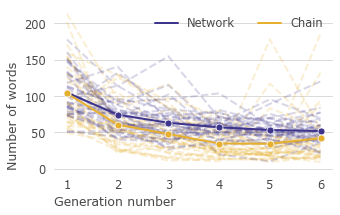

In [6]:
# Calculate words
results["n_words"] = results["story_merged"].apply(lambda x: len(x.split()))

# Plot indiviudal traces
plot_agg(results, x="layer_n",y="n_words",hue="condition")

# Plot average
sns.lineplot(x="layer_n",y="n_words",hue="condition", estimator=np.mean,
             palette=cond2color, data=results,lw=2,marker="o",markersize=7,ci=None)

# Standard style + label
set_style("Number of words")

# Save plot
plt.savefig(f"{path_figures}/h2_number_words.pdf", bbox_inches="tight")

# Calculate similarities

In [9]:
# Create jaccard similarity
results_jac = create_similarity(results.copy(),stop_words=eng_stopwords)
results_jac.to_csv(f'{path_data_files}/data_processing/analysis_similarity_transformers.csv')

,Unnamed: 0,layer_n,rep,story1,story2,story3,story_merged,condition,n_words,story_original,...,jaccard_3,jaccard_previous_layer,jaccard_original_story,jaccard_os_1,jaccard_os_2,jaccard_os_3,jaccard_wl_12,jaccard_wl_13,jaccard_wl_23,jaccard_within_layer
0,0,1,1,"{become, childhood, insisting, ear, battlefiel...","{become, childhood, insisting, ear, battlefiel...","{become, childhood, insisting, ear, battlefiel...","{become, childhood, insisting, ear, battlefiel...",Network,148,"{ii, available, diseases, states, now, respond...",...,1.000000,1.000000,0.138211,0.138211,0.138211,0.138211,1.000000,1.000000,1.0,1.000000
1,1,1,1,"{war, public, diseases, infection, use, develo...","{war, public, diseases, infection, use, develo...","{war, public, diseases, infection, use, develo...","{war, public, diseases, infection, use, develo...",Network,85,"{ii, available, diseases, states, now, respond...",...,1.000000,1.000000,0.131222,0.131222,0.131222,0.131222,1.000000,1.000000,1.0,1.000000
2,2,1,1,"{become, resistant, deal, fast, use, antibioti...","{become, resistant, deal, fast, use, antibioti...","{become, resistant, deal, fast, use, antibioti...","{become, resistant, deal, fast, use, antibioti...",Network,70,"{ii, available, diseases, states, now, respond...",...,1.000000,1.000000,0.070485,0.070485,0.070485,0.070485,1.000000,1.000000,1.0,1.000000
3,3,2,1,"{become, childhood, insisting, ear, battlefiel...","{war, public, diseases, infection, use, develo...","{become, resistant, deal, fast, use, antibioti...","{antibiotics, many, lifesaving, square, change...",Network,66,"{ii, available, diseases, states, now, respond...",...,0.084746,0.086022,0.025974,0.138211,0.131222,0.070485,0.175258,0.080808,0.1,0.118689
4,4,2,1,"{become, childhood, insisting, ear, battlefiel...","{war, public, diseases, infection, use, develo...","{become, resistant, deal, fast, use, antibioti...","{developed, infection, saved, antibiotics, res...",Network,59,"{ii, available, diseases, states, now, respond...",...,0.087719,0.277778,0.093023,0.138211,0.131222,0.070485,0.175258,0.080808,0.1,0.118689


In [11]:

def transformer_similarity(sentence1, sentence2, model):
    global global_emb
    
    if sentence1 in global_emb:
        embeddings1 = global_emb[sentence1]
    else:
        embeddings1 = model.encode([sentence1], convert_to_tensor=True)
        global_emb[sentence1] = embeddings1
    
    if sentence2 in global_emb:
        embeddings2 = global_emb[sentence2]
    else:
        embeddings2 = model.encode([sentence2], convert_to_tensor=True)
        global_emb[sentence2] = embeddings2
    
    
    #Compute cosine-similarits
    return float(util.pytorch_cos_sim(embeddings1, embeddings2)[0][0])



In [12]:
# Create transformer similarity

#Transformers (don't run unless necessary, downloads 2gb data)
#model_t = SentenceTransformer('sentence-transformers/paraphrase-xlm-r-multilingual-v1') #original results
model_t = SentenceTransformer('sentence-transformers/all-mpnet-base-v2') #better transformer

global_emb = dict()

#Transformer model
def w2t(strs,model=model_t):
    str1,str2 = strs
    if isinstance(str1,float) or isinstance(str2,float):
        return np.NaN
    return transformer_similarity(str1,str2, model)


results_trans = create_similarity(results,w2t,create_set=False,stop_words=None,tokenize=False)

sentences = ["go virus","bacteria kills"]
transformer_similarity(*sentences,model_t)

0.29197198152542114

In [20]:
# Save to use in next analysis
results_trans.to_csv(f'{path_data_files}/data_processing/analysis_similarity_transformers.csv')
results_trans[["layer_n","rep","condition","jaccard_original_story"]].head()

,layer_n,rep,condition,jaccard_original_story
0,1,1,Network,0.782817
1,1,1,Network,0.783907
2,1,1,Network,0.650665
3,2,1,Network,0.769188
4,2,1,Network,0.665215


# H2: Similarity with the original story

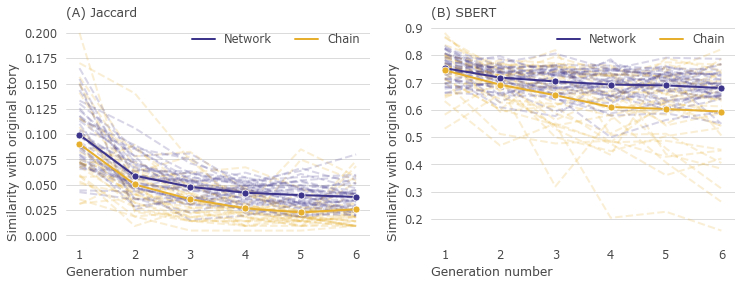

In [77]:
plt.figure(figsize=(12,4))

ax1 = plt.subplot(121)
plot_agg(results_jac, x="layer_n",y="jaccard_original_story",hue="condition")
sns.lineplot(x="layer_n",y="jaccard_original_story",hue="condition",data=results_jac,lw=2,marker="o",markersize=7,palette=cond2color, ax=ax1, ci=None)
set_style("Similarity with original story")
ax1.set_title("(A) Jaccard", loc="left")

ax2 = plt.subplot(122)
plot_agg(results_trans, x="layer_n",y="jaccard_original_story",hue="condition")
sns.lineplot(x="layer_n",y="jaccard_original_story",hue="condition",data=results_trans,lw=2,marker="o",markersize=7,palette=cond2color, ax=ax2, ci=None)
set_style("Similarity with original story")
ax2.set_title("(B) SBERT", loc="left")

plt.savefig(f"{path_figures}/h2_similarity_original_story.pdf", bbox_inches="tight")

# H3: Similarity within layer (independent replicates)

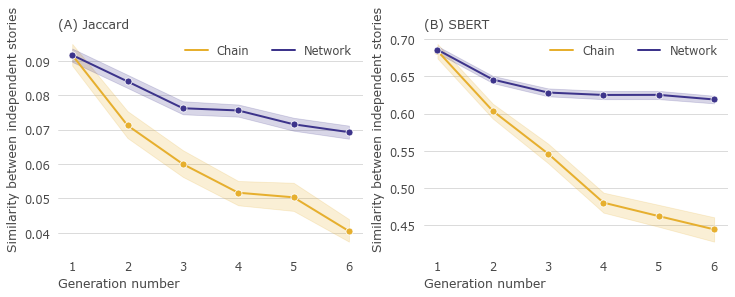

In [78]:
plt.figure(figsize=(12,4))

ax1 = plt.subplot(121)
r1 = main_similarity_indep_replicates(results_jac,jaccard,ax=ax1)
ax1.set_title("(A) Jaccard", loc="left")

ax2 = plt.subplot(122)
_ = main_similarity_indep_replicates(results_trans,w2t,ax=ax2)
ax2.set_title("(B) SBERT", loc="left")

plt.savefig(f"{path_figures}/h3_similarity_between_replicates.pdf", bbox_inches="tight")

(-0.01, 1.0)

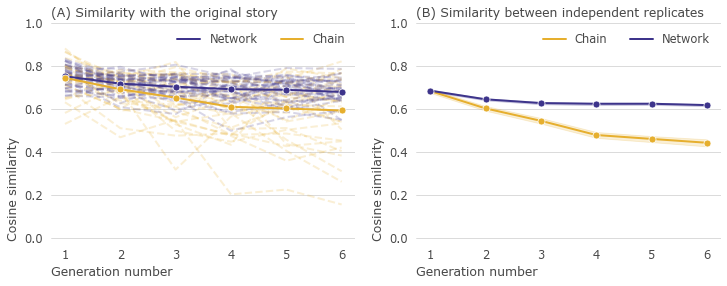

In [26]:
## Figure 2 (network are more consistent)
plt.figure(figsize=(12,4))

ax1 = plt.subplot(121)
plot_agg(results_trans, x="layer_n",y="jaccard_original_story",hue="condition")
sns.lineplot(x="layer_n",y="jaccard_original_story",hue="condition",data=results_trans,lw=2,marker="o",markersize=7,palette=cond2color, ax=ax1, ci=None)
set_style("Cosine similarity")
ax1.set_title("(A) Similarity with the original story", loc="left")
ax1.set_ylim(-0.01,1)

ax2 = plt.subplot(122)
sim_ind = main_similarity_indep_replicates(results_trans,w2t,ax=ax2)
set_style("Cosine similarity")
ax2.set_title("(B) Similarity between independent replicates", loc="left")
#sns.lineplot(x="layer_n",y="jaccard_original_story",hue="condition",alpha=0.4,legend=None,data=results_trans,lw=2,marker=".",markersize=10,palette=cond2color, ax=ax2, errorbar=None, linestyle="--")
ax2.set_ylim(-0.01,1)
#plt.suptitle("Participants in the network condition remember more consistent inormation", ha="left", x=0.08, y=1.01)
#plt.savefig(f"{path_figures}/fig_2_network_consistent.pdf", bbox_inches="tight")

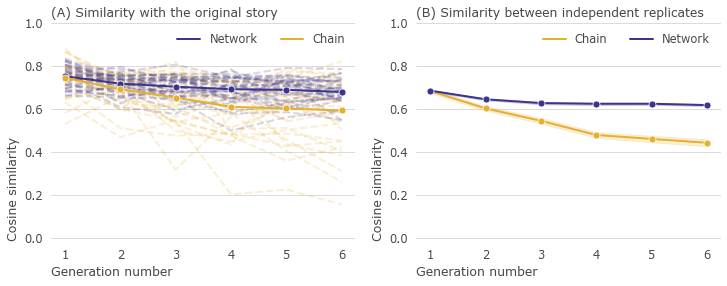

In [31]:
# Save to use in next analysis
sim_ind.to_csv(f'{path_data_files}/data_processing/analysis_similarity_ind_transformers.csv')
sim_ind.sort_values(by=["condition","k","layer_n"]).tail(30)

,condition,layer_n,k,story_merged
7390,Network,6,2,0.776695
7391,Network,6,2,0.494346
7392,Network,6,2,0.493790
7393,Network,6,2,0.580024
7394,Network,6,2,0.467075
7395,Network,6,2,0.601416
7396,Network,6,2,0.645517
7397,Network,6,2,0.583932
7398,Network,6,2,0.672692
7399,Network,6,2,0.734719


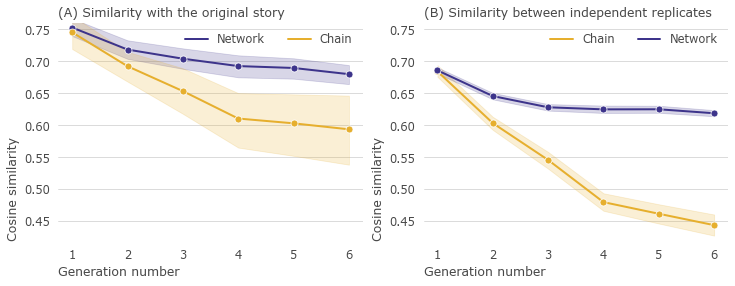

In [79]:
## Figure 2 (network are more consistent)
plt.figure(figsize=(12,4))

ax1 = plt.subplot(121)
#plot_agg(results_trans, x="layer_n",y="jaccard_original_story",hue="condition")
sns.lineplot(x="layer_n",y="jaccard_original_story",hue="condition",data=results_trans,lw=2,marker="o",markersize=7,palette=cond2color, ax=ax1)#, ci=None)
set_style("Cosine similarity")
ax1.set_title("(A) Similarity with the original story", loc="left")
ax1.set_ylim(0.42,0.76)

ax2 = plt.subplot(122)
_ = main_similarity_indep_replicates(results_trans,w2t,ax=ax2)
set_style("Cosine similarity")
ax2.set_title("(B) Similarity between independent replicates", loc="left")
#sns.lineplot(x="layer_n",y="jaccard_original_story",hue="condition",alpha=0.4,legend=None,data=results_trans,lw=2,marker=".",markersize=10,palette=cond2color, ax=ax2, errorbar=None, linestyle="--")
ax2.set_ylim(0.42,0.76)
#plt.suptitle("Participants in the network condition remember more consistent inormation", ha="left", x=0.08, y=1.01)
plt.savefig(f"{path_figures}/fig_2_ci_network_consistent.pdf", bbox_inches="tight")

In [80]:
def find_color(title):
    if "Network" in title:
        color = cond2color["Network"]
    elif "Chain" in title:
        color = cond2color["Chain"]
    else:
        color = "gray"
    return color

In [256]:
def plot_embedded(X_embedded,data,filter_,title="Network",traces=True):
    values = sns.color_palette("rocket_r",7)
    colors_reps = sns.color_palette("tab10",len(data.loc[filter_,"rep"].unique()))

    if traces:
        for rep in sorted(data.loc[filter_,"rep"].unique()):
            filter_2 = filter_ & (data["rep"]==rep)
            plt.plot(np.concatenate([[X_embedded[-1,0]],data.loc[filter_2,"x"].values]), 
                     np.concatenate([[X_embedded[-1,1]],data.loc[filter_2,"y"].values]),
                     color=colors_reps.pop(0),zorder=0,alpha=0.5)

    
    plt.scatter(data.loc[filter_,"x"], data.loc[filter_,"y"],color=[values[_] for _ in data.loc[filter_,"layer_n"]])
    plt.scatter(X_embedded[-1,0], X_embedded[-1,1], s=150, color = "cornflowerblue")

    sns.despine(bottom=True,left=True) 
    color = find_color(title)
    plt.title(title, color=color)
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
    # Remove axis ticks
    plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
                labelbottom=False, labelleft=False)
    
def plot_transmissions(data2,traces=True):
    plt.figure(figsize=(10,4), facecolor="white")
    plt.subplot(121, facecolor='.95')
    filter_ = data2["condition"] == "Network"
    plot_embedded(X_embedded,data2,filter_,"(A) Network",traces=traces)

    plt.subplot(122, facecolor='.95')
    filter_ = data2["condition"] == "Chain"
    plot_embedded(X_embedded,data2,filter_,"(B) Chain",traces=traces)

    plt.tight_layout()

    




In [206]:
data = results.loc[:, ["layer_n","rep","condition","story_merged"]]
data.loc[9909] = [8,0,"Full",story_original]
data["k"] = data.index%3
data.loc[data["condition"].str.contains("Chain"),"k"] = 0

if 0:
    from sklearn.manifold import TSNE

    # Embedd results
    emb = model_t.encode(data["story_merged"].values, convert_to_tensor=True)


    X_embedded = TSNE(random_state=42, n_components=2, learning_rate='auto', n_jobs=-1).fit_transform(emb)
    print(X_embedded.shape)
    np.save("data_embedding/X_embedded.npy", X_embedded)

    print(len(data))

    # Tensors to pands
    emb_df = pd.DataFrame(np.array(emb))
    emb_df.loc[:,"condition"] = data["condition"].values
    emb_df.loc[:,"layer_n"] = data["layer_n"].values
    emb_df.loc[:,"k"] = data["k"].values
    emb_df.loc[:,"rep"] = data["rep"].values

    emb_df.to_csv("data_embedding/embeddings.csv", index=None)
    

    import umap
    reducer = umap.UMAP(random_state=42, metric="cosine").fit_transform(emb)
    X_embedded = reducer.fit_transform(emb)
    np.save("data_embedding/X_embedded_umap.npy", X_embedded)


    
else:
    emb_df = pd.read_csv("data_embedding/embeddings.csv")
    X_embedded = np.load("data_embedding/X_embedded_umap.npy")

    
xmin,ymin,xmax,ymax = np.concatenate([X_embedded.min(0)*1.1,X_embedded.max(0)*1.1])

#Add embeddment
data["x"] = X_embedded[:,0]
data["y"] = X_embedded[:,1]



In [207]:

emb_df = emb_df.loc[emb_df["k"]==0] #consider 1 replicate per network
emb_df = emb_df.reset_index(drop=True)
# Compare with mean value
average_embeddings = emb_df.groupby(["condition","k","layer_n"]).transform(np.mean)

col_emb = [str(_) for _ in range(768)] if "1" in list(emb_df.columns) else range(768)
for i in range(len(emb_df)):
    emb_df.loc[i, "distance"] = 1-cosine_similarity([emb_df.loc[i, col_emb].values], [average_embeddings.loc[i, col_emb].values])[0][0]
emb_df.head()



/var/folders/hx/nz98f65j615c4ygz7xt694700000gp/T/ipykernel_94830/3871908595.py:4: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the transforming function.
  average_embeddings = emb_df.groupby(["condition","k","layer_n"]).transform(np.mean)


,0,1,2,3,4,5,6,7,8,9,...,763,764,765,766,767,condition,layer_n,k,rep,distance
0,0.023449,0.043154,0.028949,-0.040941,0.067682,-0.003374,-0.017990,0.025976,0.019632,-0.026748,...,0.004801,0.016738,-0.014615,0.023646,-0.051167,Network,1,0,1,0.164006
1,0.032154,0.041539,0.014819,-0.032326,0.012568,-0.014821,0.019612,-0.003358,0.017771,-0.001400,...,-0.010102,0.012869,0.029976,0.060440,-0.036034,Network,2,0,1,0.204662
2,0.006970,0.099449,0.015318,-0.062665,0.024461,0.003387,0.027335,0.036748,0.024537,0.012425,...,0.009213,-0.021164,-0.015734,0.019184,-0.010313,Network,3,0,1,0.442331
3,0.007427,-0.033973,0.014262,-0.036670,0.038991,-0.039663,-0.011086,-0.000759,0.044471,0.000057,...,0.038081,0.001239,-0.003544,0.060541,-0.060049,Network,4,0,1,0.194720
4,0.005043,0.002582,0.015815,-0.059984,0.054724,-0.030519,-0.008002,0.019181,0.028124,-0.017472,...,0.009022,0.050617,-0.020310,0.092464,-0.053468,Network,5,0,1,0.196860


MannwhitneyuResult(statistic=5551.0, pvalue=1.2084430771677279e-09)


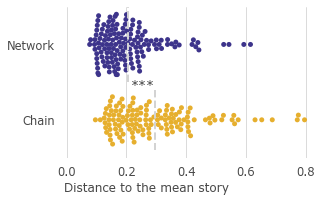

In [249]:
from scipy.stats import mannwhitneyu
d_comp = emb_df.loc[(emb_df["condition"]!="Full") & (emb_df["layer_n"]>=-3+comparison_layer)]
sns.catplot(y="condition",x="distance",data=d_comp, kind="swarm",palette=cond2color,
           aspect=1.6,height=3)

n = d_comp.loc[d_comp["condition"]=="Network", "distance"]
c = d_comp.loc[d_comp["condition"]=="Chain", "distance"]
print(mannwhitneyu(n, c, alternative="less"))
plt.plot([n.mean(),n.mean()],[0.5,-0.5],  "--", color="lightgray", zorder=9)
plt.plot([c.mean(),c.mean()],[0.6,1.4],  "--", color="lightgray", zorder=9)
plt.annotate("***", (0.255, 0.55), ha="center", va="center")

plt.xlabel("Distance to the mean story", fontsize=12)
plt.ylabel("")
plt.gca().grid(axis="x")
sns.despine(left=True, bottom=True)
plt.xlim(-0.01, 0.81)
plt.tight_layout
plt.savefig(f"{path_figures}/fig_spread.pdf", bbox_inches="tight")

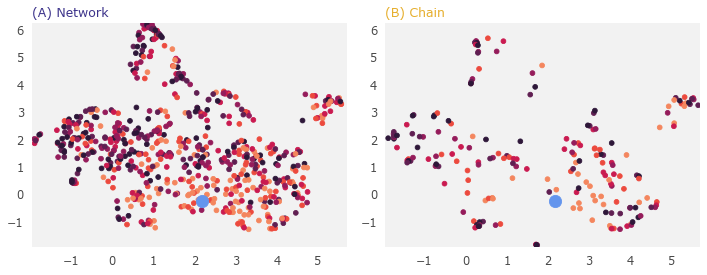

In [253]:
xmin,ymin,xmax,ymax = np.concatenate([X_embedded.min(0)-0.05,X_embedded.max(0)+0.05])
plot_transmissions(data, traces=False)
plt.savefig(f"{path_figures}/umap.pdf", bbox_inches="tight")

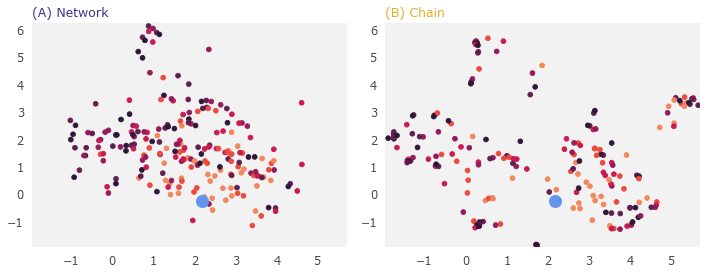

In [255]:
xmin,ymin,xmax,ymax = np.concatenate([X_embedded.min(0)-0.05,X_embedded.max(0)+0.05])
plot_transmissions(data.groupby(["rep","layer_n","condition"]).mean().reset_index(), traces=False)
plt.savefig(f"{path_figures}/umap_mean.pdf", bbox_inches="tight")


In [271]:
data.loc[(data["x"]>1) & (data["y"]>1)  & (data["x"]<4)  & (data["layer_n"]>4) & (data["condition"]=="Network"), "story_merged"].head(4).values

array(['People are using too many antibiotics. His is weakening the ability to fight viruses.',
       'When antibiotics where first made they helped fight viruses and helped people live longer. These days people are using antibiotics to much making them less effective',
       'Cancer and heart disease are limiting the ability of individuals to live longer lives. Prior to the development of antibiotics the main culprits were viruses. However, recently it has been noticed, that the overuse of antibiotics is once again promoting many deaths due to viruses.',
       'Year ago, people were not living long enough to die from diseases.  Then with the invention of antibiotics,technology, etc people are living longer.  Now antibiotics are used to much and many viruses are becoming resistant to them. '],
      dtype=object)

In [269]:
data.loc[data["story_merged"].str.contains("super bug")].mean()

/var/folders/hx/nz98f65j615c4ygz7xt694700000gp/T/ipykernel_94830/2608082585.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data.loc[data["story_merged"].str.contains("super bug")].mean()


layer_n    2.750000
k          1.277778
x          2.660554
y          1.864736
dtype: float64

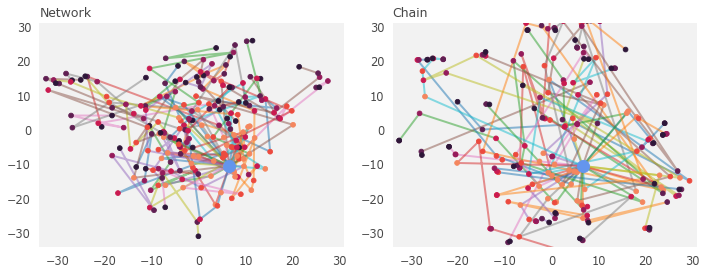

In [155]:
plot_transmissions(data.groupby(["rep","layer_n","condition"]).mean().reset_index(), traces=True)

# H4: 

$\textbf{H4 - Words that individuals transmit with a high probability will be better preserved in networks compared to chains.}$

In [17]:

def main_plot_model(k, xmin=0.5, generations=1):
    colors = sns.color_palette("Purples",k)
    
    #Probability of remembering
    p_values = np.linspace(xmin,1,1000)

    #Plot binomial
    for i in range(k):
        if i == 0:
            label=f"Intersection"
        elif i == (k-1):
            label=f"Union"
        else:
            label=f"At least {k-i}"
        
        c = colors.pop(0)
    
        #Binomial uses probability of forgetting (0 = all remember, 1 = at least one remember)
        plt.plot(p_values,binom.cdf(i,k,1-p_values)**generations,"-",color=c,label=label,lw=2)
    
        

    #1:1 line
    #plt.plot([xmin,1],[1,1],"--",color="gray",zorder=0)
    plt.plot(p_values,p_values**generations,"--",color="gold",label=None,zorder=0)
    plt.plot(p_values,p_values,"--",color="gray",label=None,zorder=0)

    #plt.yscale("log")
    
    #Legend
    plt.legend(loc=1, ncol=1, title="Remembered if:", fontsize=12, title_fontsize=12)
    #plt.legend(loc='center left', bbox_to_anchor=(0.65, 0.2), ncol=1, title="Remembered if:", fontsize=12, title_fontsize=12)
    #Labels
    plt.xlabel("Baseline probability")
    plt.ylabel(f"Frequency at generation {generations+1}")
    sns.despine(bottom=True,left=True)


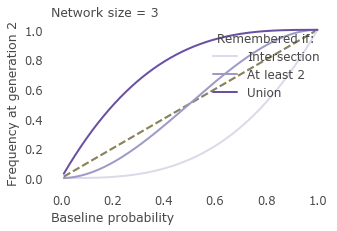

In [18]:
main_plot_model(3, xmin=0.01, generations=1)
plt.title(f"Network size = 3", loc="left")#, (1,0.1), ha="right",va="top")
plt.savefig(f"/Users/garci061/Downloads/transmission_model.pdf", bbox_inches="tight")


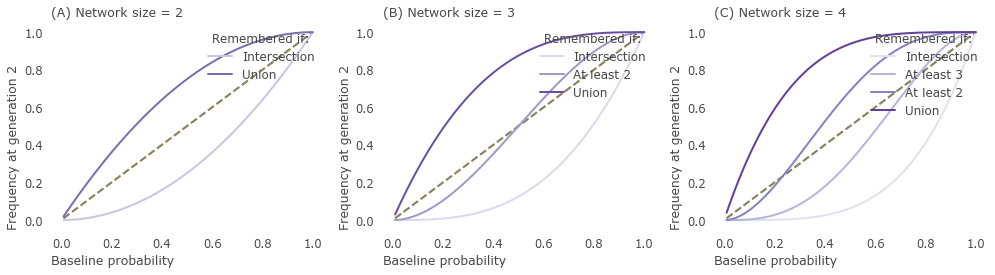

In [19]:
plt.figure(figsize=(14,4))
for i in range(2,5):
    plt.subplot(1,3,i-1)
    main_plot_model(i,xmin=0.01, generations=1)
    plt.title(f"({'ABC'[i-2]}) Network size = {i}", loc="left")#, (1,0.1), ha="right",va="top")
    #plt.ylim(1E-1,1E1)
plt.tight_layout()

#plt.savefig(f"{path_figures}/transmission_model.pdf", bbox_inches="tight")


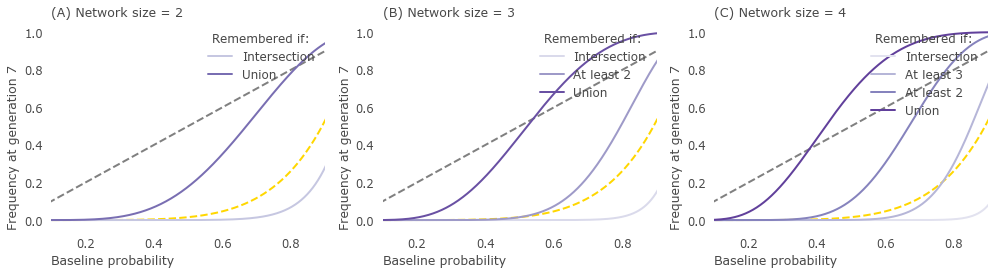

In [20]:
plt.figure(figsize=(14,4))
for i in range(2,5):
    plt.subplot(1,3,i-1)
    main_plot_model(i,xmin=0.01, generations=6)
    plt.title(f"({'ABC'[i-2]}) Network size = {i}", loc="left")#, (1,0.1), ha="right",va="top")
    plt.xlim(1E-1,0.9)
plt.tight_layout()
#plt.savefig(f"{path_figures}/transmission_model.pdf", bbox_inches="tight")


In [22]:
results2 = results.copy()
results2["story1"] = results2["story1"].str.lower()
results2["story2"] = results2["story2"].str.lower()
results2["story3"] = results2["story3"].str.lower()
results2["story_merged"] = results2["story_merged"].str.lower()

In [23]:
word = "people"
condition = "Network"
filter_ = results2["story1"].str.contains(word).astype(int)+results2["story2"].str.contains(word)+results2["story3"].str.contains(word)
filter2 = results2["story_merged"].str.contains(word)
filter3 = (results2["layer_n"]>1) & (results2["condition"]==condition)
r = np.zeros((4,2))
for i in range(4):
    for j in range(2):
        a = len(results2.loc[filter3 & (filter_==i) & (filter2==j)].sort_values(by="layer_n", ascending=False)[["story1","story2","story3","story_merged"]])
        r[i, j] = a
        
r = pd.DataFrame(r).rename_axis("Number of times observed")
r.columns = ["NT", "T"]
r["prob"] = r["T"]/(r["NT"]+r["T"])

if condition == "Network":
    r["prob_rem_none"] = binom.pmf(0,3,r["prob"])
    r["prob_rem_exac_1"] = binom.pmf(1,3,r["prob"])
    r["prob_rem_exac_2"] = binom.pmf(2,3,r["prob"])
    r["prob_rem_all_3"] = binom.pmf(3,3,r["prob"])
    r["expected_next_gen"] = r["prob_rem_exac_1"]*1+r["prob_rem_exac_2"]*2+r["prob_rem_all_3"]*3
#    r["prob_completely_losing_it"] = r["prob"]*(1-r["prob"])**(r.index-1)

    
r.round(2).dropna()



,NT,T,prob,prob_rem_none,prob_rem_exac_1,prob_rem_exac_2,prob_rem_all_3,expected_next_gen
Number of times observed,,,,,,,,
0,30.0,9.0,0.23,0.46,0.41,0.12,0.01,0.69
1,59.0,31.0,0.34,0.28,0.44,0.23,0.04,1.03
2,54.0,93.0,0.63,0.05,0.26,0.44,0.25,1.90
3,39.0,225.0,0.85,0.00,0.06,0.32,0.62,2.56


In [24]:
binom.pmf(range(4), 3, 0.8)

array([0.008, 0.096, 0.384, 0.512])

In [25]:
def decay(p, max_iter=10000):
    freq = binom.pmf(range(4), 3, p[3]) 
    matrix = np.vstack([binom.pmf(range(4), 3, _) for _ in p]).T
    e_ind = 1/freq[0]
    
    if p[3] == 1:
        return np.inf
    if p[3] == 0:
        return 1
    
    old_freq = freq[0]
    expected = 1*old_freq
    old_expected = -9
    for i in range(2, max_iter):
        freq = matrix @ freq
        expected += i*(freq[0]-old_freq)
        old_freq = freq[0]
        #print(i, expected, old_expected)
#         if (expected>(1+p[-1])) & (np.abs(expected-old_expected)<1E-4):
#             return expected
        old_expected = expected
    #print(f"Did not converge {p[-1]}")
    return freq[0]

    
def create_probs(prob, decay=1):
    n_remembered = np.arange(1,4)
    if prob==1:
        return [0,1,1,1]
    o = prob/(1-prob)
    o = np.exp(np.log(o)-decay*prob*(3-(n_remembered))-0.45587*np.log(3)+0.1)
    r = o/(o+1)
    return [0]+list(r)

create_probs(0.9, 1)

[0, 0.49910004929711427, 0.7102091798570646, 0.8577101677905264]

/var/folders/hx/nz98f65j615c4ygz7xt694700000gp/T/ipykernel_21051/1798231254.py:31: RuntimeWarning: divide by zero encountered in log
  o = np.exp(np.log(o)-decay*prob*(3-(n_remembered))-0.45587*np.log(3)+0.1)
/var/folders/hx/nz98f65j615c4ygz7xt694700000gp/T/ipykernel_21051/1798231254.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  e_ind = 1/freq[0]


Text(0, 0, 'p(transmission) over 6 generation')

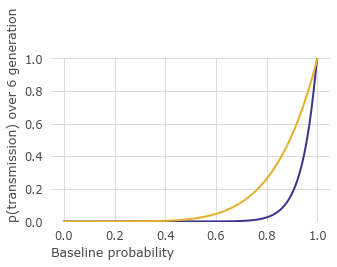

In [29]:
max_iter = 6
decay_value = 5
probs = np.linspace(0,1,1000)
adjusted_probs = [create_probs(_, decay=decay_value) for _ in probs]
time_to_extinguishment = [1-decay(_, max_iter=max_iter) for _ in adjusted_probs]
time_to_extinguishment = [_ if np.isfinite(_) else max_iter for _ in time_to_extinguishment]
#time_to_extinguishment_c = [1+p/(1-p) for p in probs]
time_to_extinguishment_c = [p**max_iter for p in probs]
time_to_extinguishment_c = [_ if np.isfinite(_) else max_iter for _ in time_to_extinguishment_c]
plt.plot(probs, time_to_extinguishment)
plt.plot(probs, time_to_extinguishment_c)
# plt.yscale("log")
plt.ylim(0,1)
# plt.xscale("log")
plt.grid()
plt.xlabel("Baseline probability")
plt.ylabel("p(transmission) over 6 generation")

In [30]:
matrix = np.vstack([binom.pmf(range(4), 3, _) for _ in adjusted_probs[-2]]).T
freq = binom.pmf(range(4), 3, adjusted_probs[-2][-1]) 
(matrix @ freq)

array([3.25841060e-05, 3.66685118e-04, 6.07519445e-03, 9.93525536e-01])

In [31]:
p = np.array([0,0.5,0.8,0.9])
freq = binom.pmf(range(4), 3, p[3]) 
matrix = np.vstack([binom.pmf(range(4), 3, _) for _ in p]).T
x = (100*pd.DataFrame(matrix.round(3), index=["0","1","2","3"], columns=["Received from 0", "1", "2", "3"]).T).round(0)
x = x.astype(int).style.background_gradient(cmap='YlOrBr')
x


,0,1,2,3
Received from 0,100,0,0,0
1,12,38,38,12
2,1,10,38,51
3,0,3,24,73


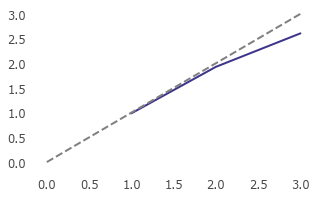

In [32]:
prob = 0.8
n_remembered = np.arange(1,4)
o = prob/(1-prob)
o = np.exp(np.log(o)+0.5-1.3*(3-(n_remembered)))
r = o/(o+1)

r2 = binom.pmf(1,3,r)+binom.pmf(2,3,r)*2+binom.pmf(3,3,r)*3
plt.plot(np.arange(1,4),r2)
plt.plot([0,3],[0,3], "--", color="gray")

,NT,T,p(Transmission)
Number of times observed,,,
1,13.0,14.0,0.52
2,23.0,94.0,0.80
3,29.0,364.0,0.93


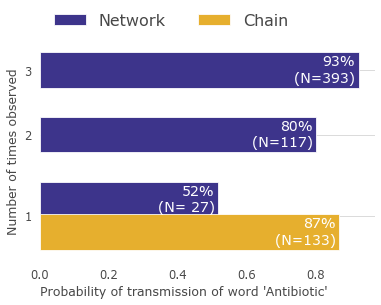

In [776]:
word = "antibiotic"
filter_ = results2["story1"].str.contains(word).astype(int)+results2["story2"].str.contains(word)+results2["story3"].str.contains(word)
filter2 = results2["story_merged"].str.contains(word)
filter3 = (results2["layer_n"]>1) & (results2["condition"]=="Network")
r = np.zeros((4,2))
for i in range(4):
    for j in range(2):
        a = len(results2.loc[filter3 & (filter_==i) & (filter2==j)].sort_values(by="layer_n", ascending=False)[["story1","story2","story3","story_merged"]])
        r[i, j] = a
        
r = pd.DataFrame(r).rename_axis("Number of times observed")
r.columns = ["NT", "T"]
r["p(Transmission)"] = r["T"]/(r["NT"]+r["T"])
r = r.drop([0])
plt.barh(r.index, r["p(Transmission)"], color=palette[0], height=0.55, label="Network")
plt.barh(0.5, 0.87, color=palette[1], height=0.55, label="Chain")
plt.annotate(f"{0.87:2.0%}\n (N={116+17:3.0f})", (0.87-0.01, 0.5), va="center", ha="right", fontsize=14, color="white")
plt.yticks([0.75,2,3], [1,2,3])
plt.grid(axis="y")
plt.ylabel("Number of times observed", ha="center")
plt.xlabel("Probability of transmission of word 'Antibiotic'")
for i,row in r.iterrows():
    n = row["NT"]+row["T"]
    plt.annotate(f"{row['p(Transmission)']:2.0%}\n (N={n:3.0f})", (row["p(Transmission)"]-0.01, i), va="center", ha="right", fontsize=14, color="white")
plt.legend(loc='center left', bbox_to_anchor=(0, 1.1), fontsize=16, ncol=2)
plt.savefig(f"/Users/garci061/Downloads/antibiotic.pdf", bbox_inches="tight") 
r = r.round(2).dropna()
# r.index = [0,1]
r



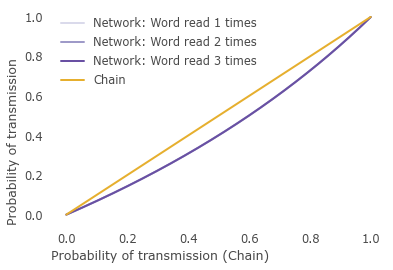

In [793]:
prob = np.linspace(0,1,1000)
o = prob/(1-prob)

colors = sns.color_palette("Purples",3)
for n_remembered in range(1,4):
    o2 = np.exp(np.log(o)-0*prob*(3-(n_remembered))-0.45587*np.log(3)+0.1)
    r = o2/(o2+1)
    plt.plot(prob, r, label=f"Network: Word read {n_remembered} times", color=colors.pop(0))

o2 = np.exp(np.log(o))
r = o2/(o2+1)
plt.plot(prob, r, label="Chain", color=palette[1])
    
plt.legend()
plt.xlabel("Probability of transmission (Chain)")
plt.ylabel("Probability of transmission")
plt.savefig(f"/Users/garci061/Downloads/model.pdf", bbox_inches="tight") 


In [455]:
all_persons.loc[(all_persons["number_stories_observed"]==3) & 
                (all_persons["layer_n"]>1) & 
                (all_persons["condition"]=="Network"), "word"].value_counts()

antibiot      390
peopl         264
resist        177
die           153
infect        147
use           117
bacteria       96
live           63
penicillin     54
cancer         51
diseas         36
year           21
save           21
develop        21
heart          18
effect         18
time           15
long           15
treat          12
like           12
death           9
2050            9
fight           9
take            9
injuri          9
million         9
enough          9
could           9
food            9
attack          6
discov          6
way             6
new             6
them            6
help            6
chang           6
drug            6
lifestyl        3
one             3
1928            3
common          3
fleme           3
10              3
work            3
thing           3
step            3
bacteri         3
end             3
Name: word, dtype: int64

## Statistical model

### Create data (tidy format)

In [15]:
# Create dataframe to calculate frequencies

# original story as set of words (stemmed)
set_story_original = set(story2set(story_original, stop_words=eng_stopwords))
set_story_original = set([ps.stem(_) for _ in set_story_original])

# create sets and stem words of the transmitted stories
results_prob = results[["story1", "story2", "story3", "story_merged","layer_n","rep","condition"]]

for s in ["story1", "story2", "story3", "story_merged"]:
    results_prob[s] = results_prob[s].apply(story2set,create_set=False,stop_words=eng_stopwords)
    results_prob[s] = results_prob[s].apply(lambda x: [ps.stem(_) for _ in x])
    results_prob[s] = results_prob[s].apply(lambda x: [_ for _ in x if _ in set_story_original])    
    
    
# tidy text structure (one word|replicate|condition per row)
all_persons = []

for i,row in results_prob.iterrows():
    stories = list((row["story1"])) + list((row["story2"])) + list((row["story3"]))
    stories = Counter(stories)
    if len(stories) == 0:
        continue
    person = pd.DataFrame.from_dict(stories, orient="index").reset_index()
    person.columns = ["word", "number_observed"]
    
    stories = list(set(row["story1"])) + list(set(row["story2"])) + list(set(row["story3"]))
    len_stories = len(row["story1"]) + len(row["story2"]) + len(row["story3"])
    if (row["condition"] == "Chain") or (row["layer_n"]==1):
        len_stories /= 3
    stories = Counter(stories)
    if len(stories) == 0:
        continue
    person1 = pd.DataFrame.from_dict(stories, orient="index").reset_index()
    person1.columns = ["word", "number_stories_observed"]
    person = pd.merge(person, person1)
    
    person["transmitted"] = person["word"].isin(set(row["story_merged"]))
    person["number_words_read"] = len_stories
    person["condition"] = row["condition"]
    person["layer_n"] = row["layer_n"]
    person["rep"] = row["rep"]
    
    all_persons.append(person)


all_persons = pd.concat(all_persons)
all_persons["transmitted"] = all_persons["transmitted"].astype(int)
all_persons.loc[(all_persons["condition"]=="Network") & (all_persons["layer_n"]==1), "condition"] = "Chain"
all_persons.loc[:, ["number_observed", "number_stories_observed"]] /= 3 #make mean, and fraction fo stories
all_persons.head()

,word,number_observed,number_stories_observed,transmitted,number_words_read,condition,layer_n,rep
0,histori,1.0,1.0,0,265.0,Chain,1,1
1,peopl,4.0,1.0,1,265.0,Chain,1,1
2,die,4.0,1.0,1,265.0,Chain,1,1
3,cancer,1.0,1.0,1,265.0,Chain,1,1
4,heart,1.0,1.0,1,265.0,Chain,1,1


In [28]:
mean_words_read = all_persons.drop_duplicates(subset=["condition","layer_n","rep"]).groupby(["condition", "layer_n"]).mean()["number_words_read"].reset_index()
mean_words_read = pd.pivot_table(mean_words_read, values="number_words_read", columns="condition", index="layer_n")
mean_words_read["ratio"] = mean_words_read["Network"]/mean_words_read["Chain"]
mean_words_read

condition,Chain,Network,ratio
layer_n,,,
1,265.000000,NaN,NaN
2,32.361111,103.805556,3.207725
3,16.555556,64.194444,3.877517
4,12.333333,52.250000,4.236486
5,8.944444,45.805556,5.121118
6,7.685714,43.500000,5.659851


In [30]:
mean_words_read.loc[2:].mean()

condition
Chain      15.576032
Network    61.911111
ratio       4.420540
dtype: float64

### Simple statistical mdoel
prob transmission in layer 1 vs layer 5

<AxesSubplot:xlabel='base_frequency', ylabel='Count'>

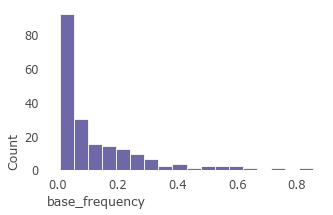

In [16]:
if 1:
    # Probability read from model (R)
    base_freq = pd.read_csv("survival_analysis/word_baseline_probs.csv", sep="\t")
    base_freq = base_freq[["word","baseline_prob_3_word_265"]]
else:
    # Baseline probability of transmission (in the first layer)
    base_freq = all_persons.loc[(all_persons["layer_n"]==1), :].groupby("word")["transmitted"].mean().reset_index()
base_freq.columns = ["word","base_frequency"]
base_freq.sort_values(by="base_frequency").tail()
sns.histplot(base_freq["base_frequency"])

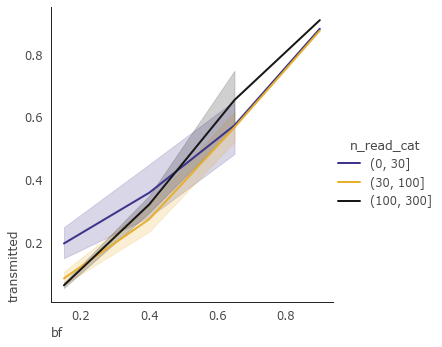

In [58]:
# Make sure the model is okay
x = all_persons.copy()
x = pd.merge(x, base_freq[["word","base_frequency"]].drop_duplicates(), how="left")
x["n_read_cat"] = pd.cut(x["number_words_read"], [0,30,100,300])
x["bf_cat"] = pd.cut(x["base_frequency"], np.linspace(0,1,5))
x = x.groupby(["condition","n_read_cat","bf_cat"]).mean()[["transmitted"]].reset_index()
x["bf"] = x["bf_cat"].astype(str).str.split("\(|,").str[1].astype(float)+0.15
sns.relplot(x="bf", y="transmitted", hue="n_read_cat", data=x, kind="line")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


   condition      word  freq
7      Chain  antibiot  21.0
82   Network  antibiot  90.0
Network    108
Chain       36
Name: condition, dtype: int64
AIC: -188, R2: 4.4%
                            OLS Regression Results                            
Dep. Variable:                   freq   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     7.801
Date:                Tue, 07 Nov 2023   Prob (F-statistic):            0.00591
Time:                        15:50:22   Log-Likelihood:                 95.853
No. Observations:                 150   AIC:                            -187.7
Df Residuals:                     148   BIC:                            -181.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err   

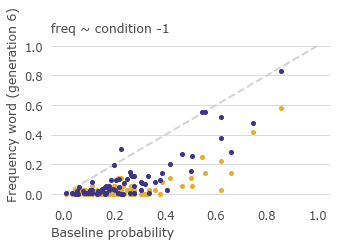

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


AIC: -346, R2: 67.1%
                            OLS Regression Results                            
Dep. Variable:                   freq   R-squared:                       0.678
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                     102.5
Date:                Tue, 07 Nov 2023   Prob (F-statistic):           9.25e-36
Time:                        15:50:22   Log-Likelihood:                 177.02
No. Observations:                 150   AIC:                            -346.0
Df Residuals:                     146   BIC:                            -334.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

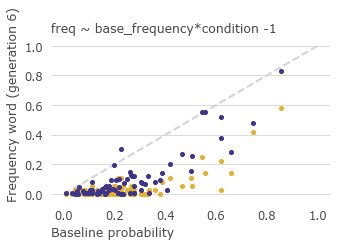

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


AIC: -410, R2: 78.6%
                            OLS Regression Results                            
Dep. Variable:                   freq   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     183.2
Date:                Tue, 07 Nov 2023   Prob (F-statistic):           2.79e-49
Time:                        15:50:22   Log-Likelihood:                 209.08
No. Observations:                 150   AIC:                            -410.2
Df Residuals:                     146   BIC:                            -398.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


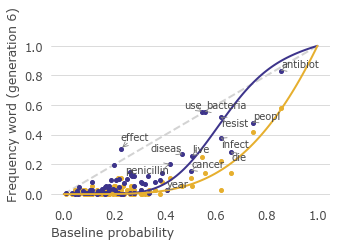

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


AIC: -418, R2: 79.9%
                            OLS Regression Results                            
Dep. Variable:                   freq   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     119.5
Date:                Tue, 07 Nov 2023   Prob (F-statistic):           1.96e-49
Time:                        15:50:23   Log-Likelihood:                 214.91
No. Observations:                 150   AIC:                            -417.8
Df Residuals:                     144   BIC:                            -399.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

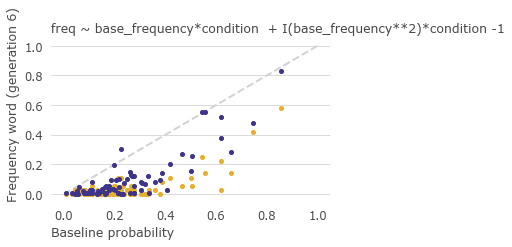

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


AIC: -424, R2: 80.8%
                            OLS Regression Results                            
Dep. Variable:                   freq   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     126.1
Date:                Tue, 07 Nov 2023   Prob (F-statistic):           8.59e-51
Time:                        15:50:23   Log-Likelihood:                 218.18
No. Observations:                 150   AIC:                            -424.4
Df Residuals:                     144   BIC:                            -406.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

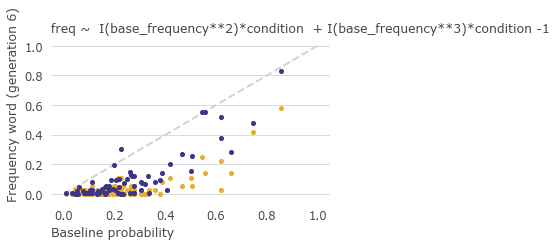

In [31]:

# Simple model
x = all_persons.loc[(all_persons["layer_n"]==comparison_layer) & (all_persons["transmitted"]==True) , ["condition","word","transmitted","number_stories_observed"]].groupby(["condition"])["word"].value_counts()
x = x.unstack().stack(dropna=False).reset_index()
x.columns = ["condition","word","freq"]
print(x.loc[x["word"]=="antibiot"])

number_replicates_person = results.loc[results['layer_n']==comparison_layer, "condition"].value_counts()
print(number_replicates_person)

x.loc[x["condition"]=="Chain", "freq"] /= number_replicates_person["Chain"]
x.loc[x["condition"]=="Network", "freq"] /= number_replicates_person["Network"]
# --> Estimating base_frequency may make more sense (otherwise affected by the number of times a word is mentioned)
y = pd.merge(x, base_freq[["word","base_frequency"]], how="outer").dropna(subset=["condition"]).fillna(0)

for formula in [
    'freq ~ condition -1',
    'freq ~ base_frequency*condition -1',
    'freq ~ I(base_frequency**2)*condition -1', 
    'freq ~ base_frequency*condition  + I(base_frequency**2)*condition -1',
    'freq ~  I(base_frequency**2)*condition  + I(base_frequency**3)*condition -1'
                ]:
    
    mod = smf.ols(formula=formula, 
                    data=y)
    res = mod.fit()
    print(f"AIC: {res.aic:2.0f}, R2: {res.rsquared_adj:2.1%}")
    print(res.summary())

    x_lim = 1
    x = np.linspace(0,x_lim,1000)

    df = pd.DataFrame(x, columns=["base_frequency"])
    for condition in ["Chain", "Network"]:
        df["condition"] = condition
        pr = res.get_prediction(df)
        pr = pr.summary_frame(alpha=0.05)
        plt.plot(y.loc[y["condition"]==condition, "base_frequency"], 
                 y.loc[y["condition"]==condition, "freq"], 
                 ".",
                 color = cond2color[condition], markersize=8)
        # plt.plot(x, pr["mean"],  alpha=1, color = cond2color[condition], label=condition)

        # plt.fill_between(x, y1=pr["mean_ci_lower"],y2=pr["mean_ci_upper"], color = cond2color[condition], alpha=0.3)
    # p and p2 come see time_to_extinguishment{,_c} in v3_simulation
    plt.legend()
    plt.title(formula)
    plt.xlabel("Baseline probability")
    plt.ylabel("Frequency word (generation 6)")
    plt.gca().grid(axis='y')
    plt.plot([0,x_lim],[0,x_lim],"--",color="lightgray",zorder=0)
    
    print(formula)
    if formula == 'freq ~ I(base_frequency**2)*condition -1':
        texts = []
        y_annotate = y.loc[((y["base_frequency"]>0.4) | (y["freq"]>0.3)) & (y["condition"] == "Network")].groupby("word").mean()
        for word, row in y_annotate.iterrows():
            texts.append(plt.text(row["base_frequency"], row["freq"], word, va="center", fontsize=10))
            
        adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))
        plt.title("")
        plt.savefig(f"{path_figures}/statistical_model.pdf", bbox_inches="tight")
        # Shortening texts
        p = [8.664132111261927e-20, 1.7914843074708215e-12, 1.661720714019949e-10, 2.540940145192163e-09, 1.7981346312575597e-08, 8.274561000506816e-08, 2.8910842306297105e-07, 8.339664926676437e-07, 2.0888883757560217e-06, 4.694389660409175e-06, 9.680402106785019e-06, 1.861396507149314e-05, 3.377411807879038e-05, 5.835283855299363e-05, 9.667967701960952e-05, 0.00015446652623109686, 0.00023906775681117577, 0.00035974979874923253, 0.0005279631853927102, 0.0007576091445911278, 0.0010652920592510644, 0.0014705485630966714, 0.001996043719259117, 0.0026677246765045596, 0.0035149224309805197, 0.004570392853218086, 0.005870288975162414, 0.007454057665439933, 0.009364255238588597, 0.011646278221632698, 0.014348007405847518, 0.01751936540067855, 0.021211790130453795, 0.025477629015897896, 0.030369460899353627, 0.0359393550392731, 0.04223807864846262, 0.049314266414573975, 0.05721356715566177, 0.06597778416802366, 0.07564402686432964, 0.08624389193207231, 0.09780269243065964, 0.11033875296680237, 0.12386278833179659, 0.13837738175411257, 0.15387657723362236, 0.17034559831105306, 0.1877607031325494, 0.2060891828517979, 0.22528950733946346, 0.24531161891950373, 0.26609737150943424, 0.28758110919676294, 0.3096903750288156, 0.33234673771962864, 0.355466721173621, 0.37896281927319786, 0.4027445763490596, 0.4267197122090791, 0.4507952695916727, 0.474878761464708, 0.49887929572638096, 0.52270865557775, 0.5462823151076011, 0.5695203714214815, 0.5923483769040512, 0.6146980578588055, 0.636507908740287, 0.6577236543900868, 0.6782985760110479, 0.6981936999628244, 0.7173778517348195, 0.7358275805520588, 0.7535269629053682, 0.7704672957896377, 0.786646692516759, 0.8020695955926658, 0.8167462222781461, 0.8306919590768064, 0.8439267215156696, 0.8564742952278868, 0.8683616735531722, 0.8796184056951399, 0.8902759679829629, 0.9003671690535416, 0.9099255978806072, 0.918985121610725, 0.9275794382021629, 0.9357416869737578, 0.9435041184204938, 0.950897823091922, 0.9579525179966308, 0.9646963879145718, 0.9711559781792095, 0.9773561349306877, 0.9833199885267622, 0.9890689757097582, 0.9946228962406498, 1]
        p2 = [3.072776216858604e-17, 5.4432810975861345e-11, 2.5152115810092266e-09, 2.4816072996628692e-08, 1.2664743892088227e-07, 4.474769052420597e-07, 1.2500940738498204e-06, 2.9668640054548657e-06, 6.246195993183462e-06, 1.1997392241192152e-05, 2.1432564649824446e-05, 3.610472213258829e-05, 5.794145615359395e-05, 8.92739052556802e-05, 0.00013286087401927162, 0.0001919081294426674, 0.0002700830074183071, 0.000371524541368752, 0.000500849380389111, 0.0006631538004687919, 0.0008640121336464889, 0.0011094719496286666, 0.0014060463251798908, 0.001760703530658418, 0.002180854452180698, 0.002674338053460944, 0.003249405164507767, 0.003914700865954734, 0.004679245718551356, 0.005552416067784146, 0.006543923634148231, 0.007663794580559271, 0.008922348230012608, 0.010330175589024873, 0.011898117815743577, 0.013637244755951452, 0.015558833655561335, 0.017674348144605227, 0.01999541757515952, 0.022533816784094406, 0.025301446340955172, 0.02831031333163528, 0.031572512719739265, 0.035100209319605995, 0.03890562040782256, 0.043000998993645324, 0.04739861776301818, 0.052110753705772915, 0.0571496734310793, 0.06252761917222445, 0.06825679547830067, 0.07434935658733198, 0.08081739447272082, 0.08767292755262282, 0.0949278900499109, 0.10259412198875589, 0.11068335981247462, 0.1192072276061823, 0.12817722890686944, 0.13760473908282686, 0.14750099826379395, 0.15787710480283657, 0.16874400925070446, 0.18011250882330854, 0.1919932423429215, 0.204396685633799, 0.21733314735305326, 0.23081276523784955, 0.2448455027502661, 0.2594411461014958, 0.27460930163744224, 0.2903593935681682, 0.3067006620240991, 0.3236421614223384, 0.34119275912693764, 0.3593611343874502, 0.3781557775406072, 0.39758498946045556, 0.4176568812428156, 0.4383793741104226, 0.4597601995256293, 0.4818068994980481, 0.5045268270750237, 0.5279271470032955, 0.5520148365507189, 0.5767966864773769, 0.6022793021458684, 0.6284691047610362, 0.65537233272981, 0.6829950431322912, 0.7113431132956127, 0.7404222424625022, 0.7702379535468882, 0.800795594969245, 0.8321003425647439, 0.8641572015576376, 0.8969710085956261, 0.9305464338382933, 0.9648879830940118, 1.0]
        # Not shortening texts
        #p = [2.4337939641783826e-20, 5.086235076328059e-13, 4.769719428815994e-11, 7.37578256378478e-10, 5.28010880368457e-09, 2.4586755547174365e-08, 8.695238731854299e-08, 2.5395859849257865e-07, 6.442465852608464e-07, 1.4667881946796118e-06, 3.065218623424832e-06, 5.974678825421721e-06, 1.0992446050547846e-05, 1.9263404038064756e-05, 3.238111830652731e-05, 5.2504936133441616e-05, 8.249312616845022e-05, 0.00012605161188206058, 0.00018789734083964386, 0.00027393477477858524, 0.00039144339246834954, 0.0005492734793452343, 0.0007580468480949081, 0.0010303585079388948, 0.0013809746945057312, 0.0018270221056343882, 0.002388162681395593, 0.003086747840067075, 0.003947945757212764, 0.0049998350736746265, 0.0062734583606504175, 0.007802828775030351, 0.009624883622443639, 0.011779379022600338, 0.014308720551230501, 0.017257725620338553, 0.020673314453387732, 0.02460412780824272, 0.029100071085555727, 0.03421178611426212, 0.039990053702329095, 0.046485131946173944, 0.05374603726564095, 0.06181977712609258, 0.07075054537234901, 0.08057889297351295, 0.09134088870237791, 0.10306728578547966, 0.11578271179720542, 0.12950489997290057, 0.1442439806249208, 0.16000185141171397, 0.17677164479166851, 0.19453731005999247, 0.2132733259008563, 0.23294455738613618, 0.25350626883083105, 0.2749043009060569, 0.2970754169646916, 0.31994781972223396, 0.34344183534443745, 0.3674707577288332, 0.3919418414490011, 0.41675742758976037, 0.4418161826775297, 0.4670144272456545, 0.492247527410241, 0.5174113203016945, 0.5424035424206837, 0.5671252290658135, 0.591482052989637, 0.6153855714254188, 0.6387543526002147, 0.6615149557831774, 0.6836027427446802, 0.7049625031150883, 0.7255488813870776, 0.7453265990236002, 0.7642704711083339, 0.7823652229806084, 0.7996051180963041, 0.8159934137159728, 0.8315416657210635, 0.8462689077046887, 0.8602007323192986, 0.8733683045825585, 0.8858073373940488, 0.8975570589095524, 0.9086591997290858, 0.9191570252104462, 0.9290944348034063, 0.9385151463310033, 0.9474619788668287, 0.955976243520422, 0.9640972472838492, 0.9718619113209259, 0.9793045018647001, 0.9864564693495316, 0.9933463896138306, 1]
        #p2 = [8.699108842649915e-18, 1.5755655178753968e-11, 7.441081474518343e-10, 7.501321286673413e-09, 3.9102535184772446e-08, 1.410739160108698e-07, 4.0230299087330245e-07, 9.7434449117876e-07, 2.0927029454264996e-06, 4.099505568471392e-06, 7.467060902448561e-06, 1.282187126426217e-05, 2.0968731323832672e-05, 3.2914601954163724e-05, 4.989199864690278e-05, 7.33816779829396e-05, 0.0001051344445217801, 0.00014719193459593934, 0.00020190626337895064, 0.0002719584476967893, 0.0003603755397843748, 0.00047054642692072405, 0.000606236268939608, 0.0007715995603041605, 0.0009711918160201872, 0.0012099798913823, 0.0014933509546134018, 0.0018271201390626078, 0.0022175369079408588, 0.0026712901697503997, 0.0031955121867409254, 0.0037977813220241977, 0.004486123673509264, 0.005269013644680069, 0.00615537350351304, 0.007154571981601618, 0.008276421965886991, 0.009531177335350551, 0.010929528994658698, 0.012482600156112723, 0.014201940920388212, 0.016099522205488864, 0.01818772907212025, 0.020479353492341628, 0.02298758660690327, 0.02572601051514451, 0.028708589639738484, 0.031949661706932926, 0.035463928381276454, 0.039266445592142915, 0.04337261358768756, 0.0477981667501956, 0.052559163205127726, 0.05767197425453172, 0.06315327366388042, 0.06902002682982783, 0.07528947985483228, 0.08197914855310615, 0.0891068074108941, 0.09669047852268016, 0.10474842052355833, 0.11329911753669518, 0.12236126815354445, 0.13195377446326437, 0.14209573114661647, 0.15280641464851835, 0.16410527244234266, 0.176011912398043, 0.1885460922652145, 0.20172770928125644, 0.21557678991394438, 0.2301134797468559, 0.2453580335153166, 0.2613308052997675, 0.2780522388827482, 0.29554285827500276, 0.31382325841559267, 0.332914096050283, 0.3528360807919112, 0.3736099663659055, 0.395256542043627, 0.4177966242657228, 0.4412510484572566, 0.46564066103594176, 0.4909863116144409, 0.5173088453973163, 0.5446290957728837, 0.5729678770999133, 0.6023459776888129, 0.6327841529766866, 0.6643031188953712, 0.6969235454313685, 0.7306660503763278, 0.7655511932665796, 0.8015994695100115, 0.8388313046984294, 0.8772670491033809, 0.9169269723533027, 0.9578312582897035, 1.0]
        plt.plot(np.linspace(0,1,100), p)#, label="Network (model)")
        plt.plot(np.linspace(0,1,100), p2)#, label="Chain (model)")
        plt.legend()
        plt.savefig(f"{path_figures}/statistical_model_plus_abm.pdf", bbox_inches="tight")
    
        #plt.savefig("/Users/garci061/Downloads/smwo.pdf", bbox_inches="tight")
    plt.show()
    

In [90]:
y_both = pd.pivot_table(y, index="word", values="freq", columns="condition")

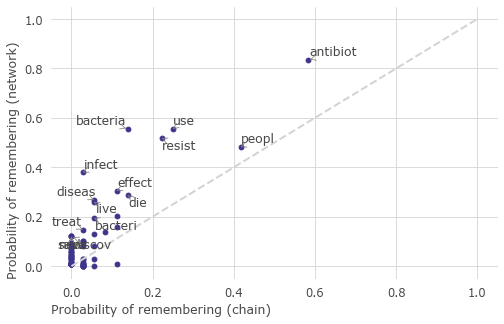

In [91]:

# sns.relplot(x="freq_y",y="freq_x",hue="condition",kind="scatter",data=y_both)
plt.figure(figsize=(8,5))

plt.plot(y_both["Chain"], y_both["Network"],"o",label=condition)
texts = []
for r,row in y_both.iterrows():
    if (row["Chain"]+0.1) < (row["Network"]) or (row["Chain"]>0.2):

        texts.append(plt.text(row["Chain"], row["Network"],r))
plt.plot([0,1],[0,1],"--",color="lightgray")
plt.grid()
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))

plt.xlabel("Probability of remembering (chain)")
plt.ylabel("Probability of remembering (network)")

plt.savefig(f"{path_figures}/words_remembered.pdf", bbox_inches="tight")
#plt.savefig("/Users/garci061/Downloads/wo.pdf", bbox_inches="tight")

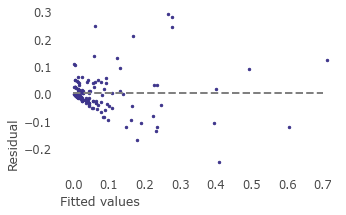

Text(0, 0, 'Residual')

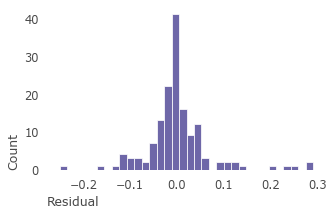

In [92]:
# quick check of the assumptions of the model
plt.plot(res.fittedvalues, res.resid, ".")
plt.plot([0,0.7],[0,0],"--",color="gray")
plt.xlabel("Fitted values")
plt.ylabel("Residual")
plt.show()

sns.histplot(res.resid)
plt.xlabel("Residual")

### Model including all terms
(to be replaced by a multilevel model, maybe)

In [93]:
test_words = all_persons.drop_duplicates(subset=["word"])
test_words["number_observed"] = 3
test_words["number_words_read"] = 579
test_words["condition"] = "Chain"
test_words.head()

,word,number_observed,number_stories_observed,transmitted,number_words_read,condition,layer_n,rep
0,histori,3,1.0,0,579,Chain,1,1
1,peopl,3,1.0,1,579,Chain,1,1
2,die,3,1.0,1,579,Chain,1,1
3,cancer,3,1.0,1,579,Chain,1,1
4,heart,3,1.0,1,579,Chain,1,1


In [97]:

# base_freq = all_persons.loc[(all_persons["layer_n"]==1), :].groupby("word")["transmitted"].mean().reset_index()
# base_freq.columns = ["word","base_frequency"]
# base_freq.head()

all_persons = pd.merge(all_persons, base_freq, how="left")
all_persons.to_csv("./survival_analysis/all_persons.csv", sep="\t", index=None)

In [98]:
all_persons.loc[all_persons["condition"]=="Network"]

,word,number_observed,number_stories_observed,transmitted,number_words_read,condition,layer_n,rep,base_frequency
579,peopl,1.000000,0.666667,0,104.0,Network,2,1,0.497625
580,use,1.000000,1.000000,0,104.0,Network,2,1,0.328917
581,die,2.000000,0.666667,0,104.0,Network,2,1,0.402196
582,heart,0.666667,0.666667,0,104.0,Network,2,1,0.307105
583,diseas,1.000000,0.666667,0,104.0,Network,2,1,0.310423
...,...,...,...,...,...,...,...,...,...
37033,get,0.333333,0.333333,0,53.0,Network,6,47,0.120132
37034,million,0.333333,0.333333,0,53.0,Network,6,47,0.270388
37035,worldwid,0.333333,0.333333,0,53.0,Network,6,47,0.048125
37036,2050,0.333333,0.333333,0,53.0,Network,6,47,0.245192


In [96]:
all_persons

,word,number_observed,number_stories_observed,transmitted,number_words_read,condition,layer_n,rep,base_frequency
0,histori,1.0,1.0,0,265.0,Chain,1,1,0.103855
1,peopl,4.0,1.0,1,265.0,Chain,1,1,0.497625
2,die,4.0,1.0,1,265.0,Chain,1,1,0.402196
3,cancer,1.0,1.0,1,265.0,Chain,1,1,0.408999
4,heart,1.0,1.0,1,265.0,Chain,1,1,0.307105
...,...,...,...,...,...,...,...,...,...
45971,food,1.0,1.0,0,12.0,Chain,5,8-2,0.176876
45972,peopl,1.0,1.0,1,7.0,Chain,6,8-2,0.497625
45973,use,2.0,1.0,1,7.0,Chain,6,8-2,0.328917
45974,live,2.0,1.0,1,7.0,Chain,6,8-2,0.304476


Optimization terminated successfully.
         Current function value: 0.375571
         Iterations: 52
         Function evaluations: 54
         Gradient evaluations: 54
34548.51338534856
                           Logit Regression Results                           
Dep. Variable:            transmitted   No. Observations:                45976
Model:                          Logit   Df Residuals:                    45969
Method:                           MLE   Df Model:                            6
Date:                Sun, 28 May 2023   Pseudo R-squ.:                  0.2480
Time:                        11:15:05   Log-Likelihood:                -17267.
converged:                       True   LL-Null:                       -22963.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                    coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------

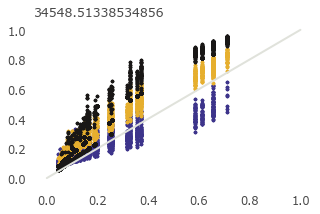

In [512]:
mod = smf.logit(formula='transmitted ~ log(number_words_read) + log(number_observed)   + \
                    base_frequency*I(3-number_stories_observed) + condition', 
                    data=all_persons)


res = mod.fit(maxiter=1000, method="bfgs")
print(res.aic)
print(res.summary())
test_words["baseline_prob"] = res.predict(exog = test_words)


all_persons_bp = pd.merge(all_persons, test_words[["word","baseline_prob"]])
network_data = all_persons_bp.loc[(all_persons_bp["condition"]=="Network")]# & (all_persons_bp["layer_n"]==3)]
network_data["prob_2"] = res.predict(exog=network_data)

for i,d in network_data.groupby("number_stories_observed"):
    plt.plot(d["baseline_prob"], d["prob_2"], ".",label=i,markersize=5)
    
plt.plot([0,1],[0,1])
plt.title(res.aic)
plt.show()




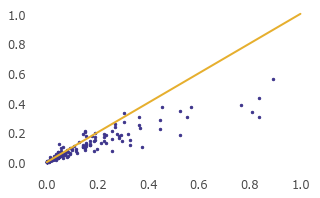

In [189]:
x = pd.merge(base_freq, test_words[["word","baseline_prob"]])
plt.plot(x["base_frequency"], x["baseline_prob"], ".")

plt.plot([0,1],[0,1])

In [196]:
from transformers import pipeline
classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", 
                      return_all_scores=True)
emotions = classifier(list(test_words["word"].values))

,word,number_observed,number_stories_observed,transmitted,number_words_read,condition,layer_n,rep,pred_prob
0,histori,3.0,3.0,0,579,Network,1,1,0.126711
1,peopl,12.0,3.0,1,579,Network,1,1,0.126711
2,die,12.0,3.0,1,579,Network,1,1,0.126711
3,cancer,3.0,3.0,1,579,Network,1,1,0.126711
4,heart,3.0,3.0,1,579,Network,1,1,0.126711
...,...,...,...,...,...,...,...,...,...
8,food,3.0,3.0,0,27,Chain,5,8-2,0.097486
0,peopl,3.0,3.0,1,12,Chain,6,8-2,0.126711
1,use,6.0,3.0,1,12,Chain,6,8-2,0.126711
2,live,6.0,3.0,1,12,Chain,6,8-2,0.126711


In [265]:
for i in range(len(test_words)):
    for j in range(7):
        em = emotions[i][j]
        label = em["label"]
        score = em["score"]
        test_words.loc[i, label] = score

[{'label': 'anger', 'score': 0.00861563440412283},
 {'label': 'disgust', 'score': 0.0039619142189621925},
 {'label': 'fear', 'score': 0.004235157743096352},
 {'label': 'joy', 'score': 0.056358885020017624},
 {'label': 'neutral', 'score': 0.7936076521873474},
 {'label': 'sadness', 'score': 0.02664310671389103},
 {'label': 'surprise', 'score': 0.10657763481140137}]

anger SpearmanrResult(correlation=0.125285759848555, pvalue=0.09378051021644272)


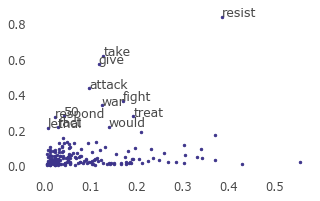

disgust SpearmanrResult(correlation=0.1375474551683694, pvalue=0.06557789547818821)


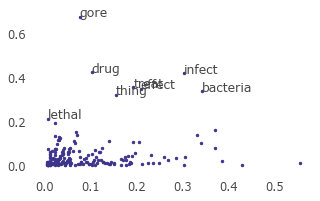

fear SpearmanrResult(correlation=0.16694136650308136, pvalue=0.025097939565931145)


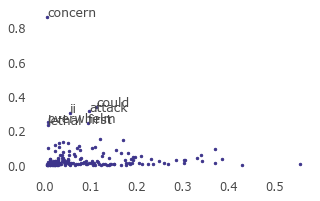

joy SpearmanrResult(correlation=-0.04888628249843102, pvalue=0.5145955071507905)


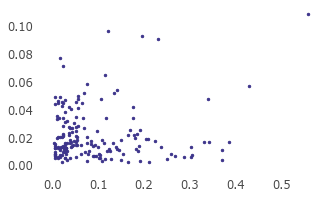

sadness SpearmanrResult(correlation=0.093449386297931, pvalue=0.21212159201599956)


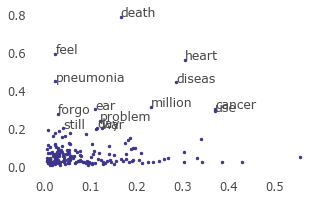

surprise SpearmanrResult(correlation=-0.12667263392903075, pvalue=0.09017325907293215)


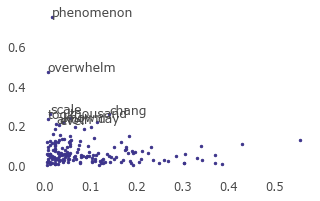

In [294]:
from scipy.stats import spearmanr, pearsonr, kendalltau
t = test_words.loc[test_words["pred_prob"]>1E-3]
for i in ["anger", "disgust", "fear", "joy", "sadness", "surprise"]:
    plt.plot(t["baseline_prob"], t[i], ".")
    print(i, spearmanr(t["pred_prob"], t[i]))
    
    for ind, row in t.iterrows():
        if row[i] > 0.2:
            plt.annotate(row["word"], (row["baseline_prob"], row[i]))
#     plt.xscale("log")
#     plt.yscale("log")
    plt.show()

In [267]:
test_words

,word,number_observed,number_stories_observed,transmitted,number_words_read,condition,layer_n,rep,pred_prob,baseline_prob,anger,disgust,fear,joy,neutral,sadness,surprise
0,histori,3,3.0,0,579,Chain,1,1,0.126711,0.103352,0.027927,0.050379,0.026490,0.004978,0.833322,0.021457,0.035447
1,peopl,3,3.0,1,579,Chain,1,1,0.752539,0.429309,0.008616,0.003962,0.004235,0.056359,0.793608,0.026643,0.106578
2,die,3,3.0,1,579,Chain,1,1,0.676212,0.340637,0.094750,0.100625,0.060815,0.047090,0.452875,0.145862,0.097983
3,cancer,3,3.0,1,579,Chain,1,1,0.426374,0.371255,0.028691,0.079464,0.095114,0.010811,0.427018,0.307189,0.051712
4,heart,3,3.0,1,579,Chain,1,1,0.355758,0.304915,0.056988,0.040637,0.029035,0.006920,0.242608,0.564815,0.058996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,routin,3,3.0,0,579,Chain,1,1,0.068594,0.055270,0.041803,0.027568,0.013594,0.049259,0.582769,0.177114,0.107893
189,thing,3,3.0,0,579,Chain,1,1,0.186405,0.153980,0.062931,0.320715,0.089156,0.007424,0.443386,0.031841,0.044547
190,slow,3,3.0,0,579,Chain,1,1,0.140084,0.114582,0.027829,0.026284,0.020499,0.004254,0.816540,0.044028,0.060566
191,arriv,3,3.0,0,579,Chain,1,1,0.028573,0.022833,0.017032,0.012098,0.014158,0.027447,0.703029,0.041147,0.185090


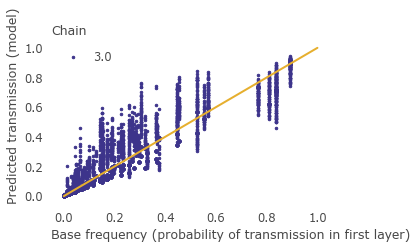

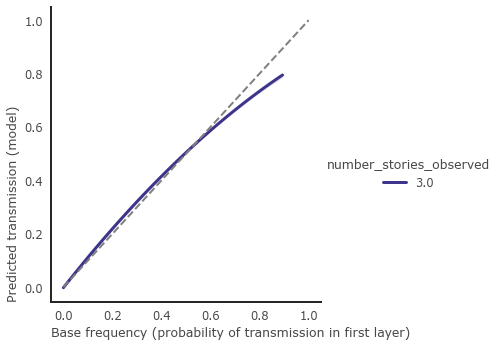

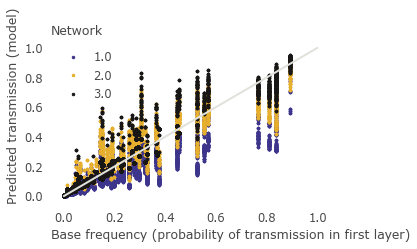

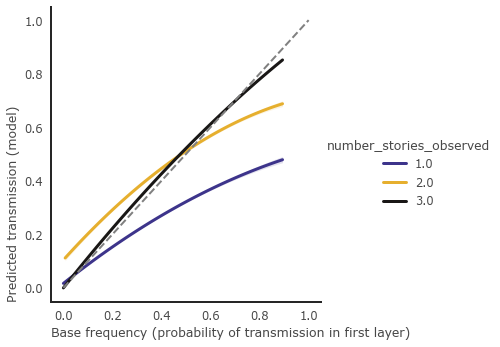

In [200]:

all_persons["pred_prob"] = res.predict(exog = all_persons.copy())

all_persons2 = pd.merge(all_persons, test_words[["word","baseline_prob"]])

ax = plt.subplot(111)
for cond,data in all_persons.groupby("condition"):
    data = pd.merge(data, base_freq.drop_duplicates())

    for i,d in data.groupby("number_stories_observed"):
        plt.plot(d["base_frequency"], d["pred_prob"], ".",label=i,markersize=5)

    plt.xlabel("Base frequency (probability of transmission in first layer)")
    plt.ylabel("Predicted transmission (model)")
    plt.plot([0,1],[0,1])
    plt.title(cond)
    plt.legend()
    plt.show()
    
    sns.lmplot(x="base_frequency", y="pred_prob",data=data,hue="number_stories_observed",order=2, scatter=False)

    plt.xlabel("Base frequency (probability of transmission in first layer)")
    plt.ylabel("Predicted transmission (model)")
    plt.plot([0,1],[0,1], "--", color="gray")
    # plt.title(cond)

    plt.show()


In [138]:
# x = [1,2,3]
# df = pd.DataFrame(x, columns=["number_stories_observed"])
# df["condition"] = "Network"
# df["number_words_read"] = 500
# df["number_observed"] = df["number_stories_observed"]
# df["word"] = "antibiot"
# pr = res.get_prediction(df)


In [149]:
#--> Marginal effect plots?
res.get_margeff(at='overall', method='dydx', atexog=None, dummy=False, count=False)

In [140]:
def plot_model(formula, data, label=None, color="gray", linestyle="-"):
    mod = smf.ols(formula=formula, 
                    data=data)
    res = mod.fit()
    print(f"AIC: {res.aic:2.0f}, R2: {res.rsquared_adj:2.1%}")
    #print(res.summary())

    x = np.linspace(0,1,1000)

    df = pd.DataFrame(x, columns=["base_frequency"])

    pr = res.get_prediction(df)
    pr = pr.summary_frame(alpha=0.0001) 
    plt.plot(x, pr["mean"],  alpha=1, color=color, label=label, linestyle=linestyle)
    plt.fill_between(x, y1=pr["mean_ci_lower"],y2=pr["mean_ci_upper"], color = color, alpha=0.3)
#     display(pr)

AIC: -312, R2: 96.2%
AIC: -3153, R2: 91.7%
AIC: -917, R2: 95.9%
AIC: -518, R2: 97.7%


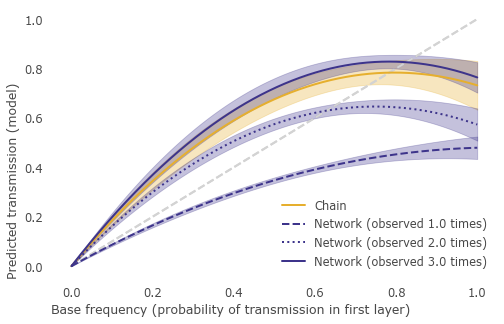

In [148]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
for cond,data in all_persons.loc[all_persons["layer_n"]==6].groupby("condition"):

    data = pd.merge(data, base_freq.drop_duplicates())

    if cond == "Chain":
        plot_model("pred_prob ~ base_frequency + I(base_frequency**2) - 1", data, color=cond2color[cond], label="Chain")
        #sns.regplot(x="base_frequency", y="pred_prob",data=data, order=2, ci=None, scatter=False, color = cond2color[cond], label=cond)
    else:
        for i, data in data.groupby("number_stories_observed"):
            plot_model("pred_prob ~ base_frequency + I(base_frequency**2) - 1", data, color=cond2color[cond], label=f"{cond} (observed {i} times)", linestyle={1:"--", 2:":", 3: "-"}[i])
            if i == 2:
                pass#sns.regplot(x="base_frequency", y="pred_prob",data=data, ci=None, order=2, scatter=True, line_kws={"linestyle": {1:"--", 2:":", 3: "-"}[i]} , color=cond2color[cond], label=f"{cond} (observed {i} times)")

    plt.xlabel("Base frequency (probability of transmission in first layer)")
    plt.ylabel("Predicted transmission (model)")
    plt.plot([0,1],[0,1], "--", color="lightgray", zorder=1)
    plt.legend()
    # plt.title(cond)

#     plt.show()
plt.savefig(f"{path_figures}/statistical_model2.pdf", bbox_inches="tight")

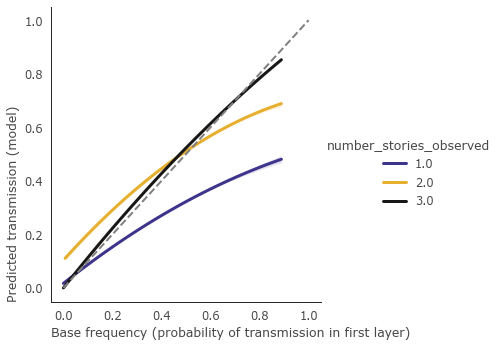

In [54]:
x = data.groupby(["word","number_stories_observed"]).mean().reset_index()



In [139]:
2/3-1

-0.33333333333333337

In [50]:
all_persons.groupby(["condition","layer_n"])["number_words_read"].mean()

condition  layer_n
Chain      1          579.000000
           2           77.091954
           3           44.832947
           4           34.633028
           5           25.598361
           6           27.000000
Network    1          579.000000
           2           78.448402
           3           47.464124
           4           39.377828
           5           33.817949
           6           33.048343
Name: number_words_read, dtype: float64

In [51]:
all_persons

,word,number_observed,number_stories_observed,transmitted,number_words_read,condition,layer_n,rep
0,histori,3.0,3.0,0,579,Network,1,1
1,peopl,12.0,3.0,1,579,Network,1,1
2,die,12.0,3.0,1,579,Network,1,1
3,cancer,3.0,3.0,1,579,Network,1,1
4,heart,3.0,3.0,1,579,Network,1,1
...,...,...,...,...,...,...,...,...
8,food,3.0,3.0,0,27,Chain,5,8-2
0,peopl,3.0,3.0,1,12,Chain,6,8-2
1,use,6.0,3.0,1,12,Chain,6,8-2
2,live,6.0,3.0,1,12,Chain,6,8-2


/var/folders/hx/nz98f65j615c4ygz7xt694700000gp/T/ipykernel_34096/148323121.py:8: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  plt.plot(prob, 100*(r/prob-1), label=f"Network: Word read {3*n_remembered} time{['s',''][3*n_remembered==1]}", color=colors.pop(0))
/var/folders/hx/nz98f65j615c4ygz7xt694700000gp/T/ipykernel_34096/148323121.py:8: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  plt.plot(prob, 100*(r/prob-1), label=f"Network: Word read {3*n_remembered} time{['s',''][3*n_remembered==1]}", color=colors.pop(0))
/var/folders/hx/nz98f65j615c4ygz7xt694700000gp/T/ipykernel_34096/148323121.py:8: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  plt.plot(prob, 100*(r/prob-1), label=f"Network: Word read {3*n_remembered} time{['s',''][3*n_remembered==1]}", color=colors.pop(0))


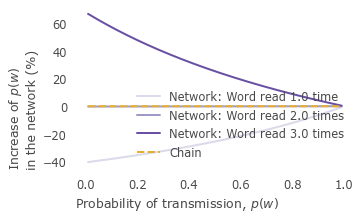

In [100]:
#How many more words read in the network
r = all_persons[["condition", "layer_n", "rep", "number_words_read"]].drop_duplicates()
r = r.groupby(["condition", "layer_n"]).mean()
r = pd.pivot_table(r, values="number_words_read", index="layer_n", columns="condition")
r["Ratio"] = r["Network"]/r["Chain"]
print(r["Ratio"].mean())
r

1.313612053377522


condition,Chain,Network,Ratio
layer_n,,,
1,579.000000,579.000000,1.000000
2,66.000000,73.250000,1.109848
3,37.181818,44.750000,1.203545
4,28.363636,36.888889,1.300570
5,20.545455,32.222222,1.568338
6,18.454545,31.361111,1.699371


In [75]:
a = x.reset_index()
a.loc[(a["layer_n"]==6)&(a["rep"]=="47")]

,index,word,number_observed,number_stories_observed,transmitted,number_words_read,condition,layer_n,rep,base_frequency
215,36969,antibiot,11.0,3.0,1,34,Network,6,47,0.529824


,Unnamed: 0,layer_n,rep,story1,story2,story3,story_merged,condition
0,0,1,1,"Through history, most people didn't die of can...","Through history, most people didn't die of can...","Through history, most people didn't die of can...",People didn't use to die of heart disease and ...,Network
1,1,1,1,"Through history, most people didn't die of can...","Through history, most people didn't die of can...","Through history, most people didn't die of can...",People didn't use to die or heart disease or c...,Network
2,2,1,1,"Through history, most people didn't die of can...","Through history, most people didn't die of can...","Through history, most people didn't die of can...",Alexander Fleming discovered penicillin in 192...,Network
3,3,2,1,People didn't use to die of heart disease and ...,People didn't use to die or heart disease or c...,Alexander Fleming discovered penicillin in 192...,Before the discovery of lifesaving antibiotics...,Network
4,4,2,1,People didn't use to die of heart disease and ...,People didn't use to die or heart disease or c...,Alexander Fleming discovered penicillin in 192...,People didn't used to die of cancer or heart d...,Network
...,...,...,...,...,...,...,...,...
859,859,2,8-2,"Before the creation of antibiotics in 1929, pe...","Before the creation of antibiotics in 1929, pe...","Before the creation of antibiotics in 1929, pe...","Before the creation of antibiotics, people did...",Chain
860,860,3,8-2,"Before the creation of antibiotics, people did...","Before the creation of antibiotics, people did...","Before the creation of antibiotics, people did...","In the old days, people did not live long enou...",Chain
861,861,4,8-2,"In the old days, people did not live long enou...","In the old days, people did not live long enou...","In the old days, people did not live long enou...",In the past people didn't live long enough to ...,Chain
862,862,5,8-2,In the past people didn't live long enough to ...,In the past people didn't live long enough to ...,In the past people didn't live long enough to ...,People used to live shorter lives because they...,Chain
